### LFP analysis
 - Created December 3, 2024 by Thomas Elston

In [1]:
# imports
from pathlib import Path
import h5_utilities as h5u
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import signal, optimize
from itertools import product
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.stats import zscore



In [2]:
# functions
def get_path_from_dir(base_folder, file_name):
    """
    Search for a file within the specified directory and its subdirectories
    by matching the given file name.

    Args:
    - base_folder (str): The directory path to start the search from.
    - file_name (str): The specific file name or part of the file name to be matched.

    Returns:
    - str or None: The path to the first file found with the given name,
      or None if no file is found.
    """
    base_folder = Path(base_folder)
    
    # Iterate through all files and directories in the base_folder
    for file in base_folder.glob('**/*'):
        if file.is_file() and file_name in file.name:
            return file.resolve()  # Return the path of the first file found with the given name
    
    # Print an error message if no file with the given name is found
    print(f"No '{file_name}' file found in the directory.")
    return None


def coherogram(lfp1, lfp2, n_perseg, n_fft, n_overlap, fq_min, fq_max, fs):
    """Computes a coherogram for an LFP stream of arbitrary length using a Hamming window.

    Inputs: 
        lfp1 (ndarray):  Datastream for one LFP channel
        lfp2 (ndarray):  Datastream for a different LFP channel
        n_perseg(int):   Window over which each piece of the coherogram is evaluated
        n_fft (int):     Number of samples to compute the FFT over (typically n_perseg)
        fq_min (int):    Minimum frequency coherence is computed at
        fq_max (int):    Maximum frequency coherence is evaluated at
        fs (int):        Sampling frequency (in Hz) of the LFP data (typically 1000 Hz)
            
    Returns:
        ts (ndarray):    Timestamps of each element of the coherogram
        coh (ndarray):   A n_frequencies x n_times array where each element describes the coherence between
                         lfp1 and lfp2 at each timestep and frequency
        z_coh (ndarray): Z-scored coherence (zscore applied to each frequency)
        freqs (ndarray): Array detailing which frquencies define the rows of coh     
    """
    
    if n_overlap < 1:
        n_overlap = int(n_overlap * n_perseg) # convert to number of segments if a fraction provided (noverlap <= 1)

    # find out the times to compute coherence at   
    ts = np.arange(0, lfp1.shape[0] + (n_perseg - n_overlap), n_perseg - n_overlap)

    n_freqs = ((fq_max - fq_min) * n_perseg // 1000) + 1

    # define the starts and stops of each window to assess coherence over
    # first columns is starts, second is stops
    win_details = np.zeros(shape=(len(ts), 2))

    # loop over each timestep and find appropriate windows. Truncate windows at the 
    # very beginning and end of of the data stream
    for i_t in range(len(ts)):

        # make centered windows
        win_details[i_t, 0] = ts[i_t] - np.floor((n_perseg/2)) # window starts
        win_details[i_t, 1] = ts[i_t] + np.floor((n_perseg/2)) # window ends

        # is the left border of the window before the start of the session?
        if win_details[i_t, 0] < 0: 
            # then set the window start to zero
            win_details[i_t, 0] = 0

        # is the right border of the window longer than the end of the session?
        if win_details[i_t, 1] > lfp1.shape[0]:
            # then set the window end to the end of the session
            win_details[i_t, 1] = lfp1.shape[0]

    # be sure these are ints
    win_details = win_details.astype(int)
    
    # run the coherence on the first window to see how many frequencies are obtained
    freqs, test_coh = signal.coherence(lfp1[0:n_perseg], lfp1[0:n_perseg], 1000, nfft=1000)
    
    n_freqs = len(freqs)

    # intialize an array to accumulate the coherence data into
    coh = np.zeros(shape=(n_freqs, len(ts)))
    coh[:] = np.nan

    # loop over each timestep
    for t in range(len(ts)):
        _, coh[:, t] = signal.coherence(lfp1[win_details[t, 0]: win_details[t, 1]],
                                           lfp2[win_details[t, 0]: win_details[t, 1]],
                                           fs=fs, nfft = n_fft, window='hamming')

    # select the frequency range defined by fq_min and fq_max
    freqs2keep = (freqs >= fq_min) & (freqs <= fq_max)

    # zscore the coherence
    z_coh = np.zeros_like(coh)
    for f in range(len(freqs)):
        f_mean = np.nanmean(coh[f,:])
        f_std = np.nanstd(coh[f,:])
        z_coh[f,:] = (coh[f,:] - f_mean) / f_std



    return ts, coh[freqs2keep,: ], z_coh[freqs2keep, :], freqs[freqs2keep]


def detrend_psd(freqs, psd):
    """
    Compute the detrended Power Spectral Density (PSD) of LFP data by removing 
    the aperiodic 1/f component.

    Parameters:
    - freqs (array): Frequencies corresponding to the PSD.
    - psd (array): PSD values from scipy.signal.welch().

    Returns:
    - freqs (array): Frequencies corresponding to the PSD.
    - psd_detrended (array): Detrended PSD values.
    """

    # Convert to log-log space for linear regression
    log_freqs = np.log10(freqs)
    log_psd = np.log10(psd)

    # Fit a power-law model (1/f) using linear regression
    slope, intercept, _, _, _ = linregress(log_freqs, log_psd)
    fit_line = slope * log_freqs + intercept

    # Subtract the fitted line (aperiodic component) from the original PSD
    psd_detrended = psd - 10 ** fit_line

    psd_detrended[0] = 0

    return freqs, psd_detrended


In [3]:
# where are the data?
data_dir = 'C:/Users/Thomas Elston/Documents/PYTHON/self_control/reprocessed_data/'

# get their relevant paths
data_files = h5u.find_h5_files(data_dir)

In [4]:
# select which file to use during this exploration
this_file = data_files[3]
h5u.list_hdf5_data(this_file)

Datasets in 'C:/Users/Thomas Elston/Documents/PYTHON/self_control/reprocessed_data\D20231221_Rec06.h5':
CdN_FR
CdN_channels
CdN_lfp
CdN_locations
CdN_mean_wf
CdN_u_names
CdN_zFR
OFC_FR
OFC_channels
OFC_lfp
OFC_locations
OFC_mean_wf
OFC_u_names
OFC_zFR
bhv
chan_map
lfp_ts
ts


In [5]:
# load the data
bhv = pd.read_hdf(this_file, key='bhv')
ofc_lfp = np.clip(h5u.pull_from_h5(this_file, 'OFC_lfp'), -1e6, 1e6)
cdn_lfp = np.clip(h5u.pull_from_h5(this_file, 'CdN_lfp'), -1e6, 1e6)
lfp_ts = h5u.pull_from_h5(this_file, 'lfp_ts')

In [6]:
# zscore the lfp
z_ofc_lfp = np.zeros((len(bhv), len(lfp_ts), 384), dtype='float16')
z_cdn_lfp = np.zeros((len(bhv), len(lfp_ts), 384), dtype='float16')


for ch in tqdm(range(384)):

    ofc_ch_mean = np.nanmean(ofc_lfp[:,:, ch])
    ofc_ch_std = np.nanstd(ofc_lfp[:,:, ch])

    z_ofc_lfp[:,:, ch] = (ofc_lfp[:,:, ch] - ofc_ch_mean) / ofc_ch_std

    cdn_ch_mean = np.nanmean(cdn_lfp[:,:, ch])
    cdn_ch_std = np.nanstd(cdn_lfp[:,:, ch])

    z_cdn_lfp[:,:, ch] = (cdn_lfp[:,:, ch] - cdn_ch_mean) / cdn_ch_std


100%|██████████| 384/384 [03:37<00:00,  1.77it/s]


In [7]:
# delete the original LFP
del ofc_lfp
del cdn_lfp

In [8]:
# let's look at the PSD over the probe
window = 'hanning'
fs = 1000
n_fft = fs
n_overlap = np.round(.5*n_fft)

ofc_pwr = np.zeros((len(bhv), 501, 384))
cdn_pwr = np.zeros((len(bhv), 501, 384))

for ch in tqdm(range(384)):
    for t in range(len(bhv)):
        fq, ofc_pwr[t,:, ch] = signal.welch(z_ofc_lfp[t,:,ch], fs=fs, noverlap=n_overlap, nfft = n_fft, nperseg=n_fft)
        fq, cdn_pwr[t,:, ch] = signal.welch(z_cdn_lfp[t,:,ch], fs=fs, noverlap=n_overlap, nfft = n_fft, nperseg=n_fft)




100%|██████████| 384/384 [05:13<00:00,  1.23it/s]


In [9]:
# calculate the channel mean PSDs
ofc_ch_means = np.nanmean(ofc_pwr, axis=0).T
cdn_ch_means = np.nanmean(cdn_pwr, axis=0).T

# subtract the aperiodic component
ofc_fooof_psd = np.zeros_like(ofc_ch_means)
cdn_fooof_psd = np.zeros_like(ofc_ch_means)

for ch in range(384):
    freqs, ofc_fooof_psd[ch, :] = detrend_psd(fq+1, ofc_ch_means[ch, :])
    _, cdn_fooof_psd[ch, :] = detrend_psd(fq+1, cdn_ch_means[ch, :])

# account for the frequency shift imposed earlier (to avoid a divide-by-zero error)
ofc_fooof_psd = np.roll(ofc_fooof_psd, 1, axis=1)
cdn_fooof_psd = np.roll(cdn_fooof_psd, 1, axis=1)

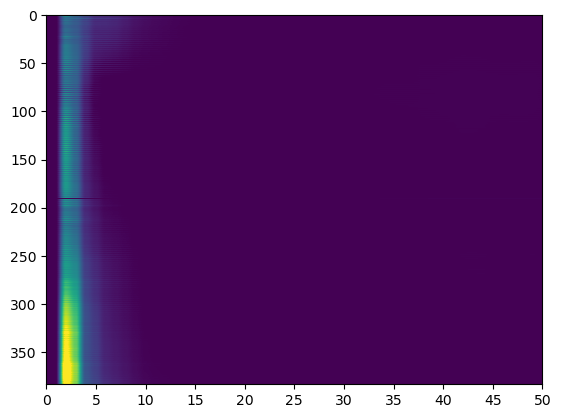

In [10]:
plt.imshow(ofc_fooof_psd, aspect='auto', vmin=0, vmax=.15)
_ = plt.xlim((0, 50))
_ = plt.xticks(np.arange(0, 55, 5))

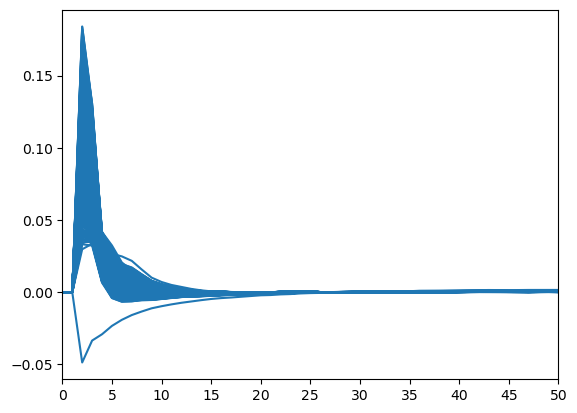

In [11]:
_ = plt.plot(fq, ofc_fooof_psd.T, color='tab:blue')
_ = plt.xlim((0, 50))
_ = plt.xticks(np.arange(0, 55, 5))

In [12]:
# signal is basically the same across the probe, so take mean over all channels
ofc_data = np.nanmean(z_ofc_lfp, axis=2)
cdn_data = np.nanmean(z_cdn_lfp, axis=2)

C:\Users\Thomas Elston\AppData\Local\Temp\ipykernel_25324\1818978841.py:2: RuntimeWarning: Mean of empty slice
  ofc_data = np.nanmean(z_ofc_lfp, axis=2)
C:\Users\Thomas Elston\AppData\Local\Temp\ipykernel_25324\1818978841.py:3: RuntimeWarning: Mean of empty slice
  cdn_data = np.nanmean(z_cdn_lfp, axis=2)


In [13]:
# run a single trial to get shape of data
ts, test_coh, _, freqs2 = coherogram(ofc_data[0,:], cdn_data[0,:], 1000, 1000, .95, 1, 50, 1000)


# initialize arrays for the trialwise coherence
coh_trials = np.zeros(shape=(len(freqs2), len(ts), len(bhv)), dtype='float16')
coh_trials[:] = np.nan
z_coh_trials = np.zeros(shape=(len(freqs2), len(ts), len(bhv)), dtype='float16')
z_coh_trials[:] = np.nan

print('\nComputing trial-by-trial coherence')
for t in tqdm(range(len(bhv))):

    if not np.isnan(np.sum(ofc_data[t,:])):
        ts, coh_trials[:,:,t], z_coh_trials[:,:,t], freqs = coherogram(ofc_data[t,:], cdn_data[t,:],
                                                                        1000, 1000, .95, 1, 50, 1000)
        
ts = ts - 1500    
t_start = np.argmin(np.abs(ts - -1000))
t_end = np.argmin(np.abs(ts - 1000))

# chop off the borders because that will blow the zscore
coh_trials = coh_trials[:,t_start:t_end,:]   
z_coh_trials = z_coh_trials[:,t_start:t_end,:]    
ts = ts[t_start:t_end]          


Computing trial-by-trial coherence


100%|██████████| 1246/1246 [01:50<00:00, 11.24it/s]


(0.0, 39.0)

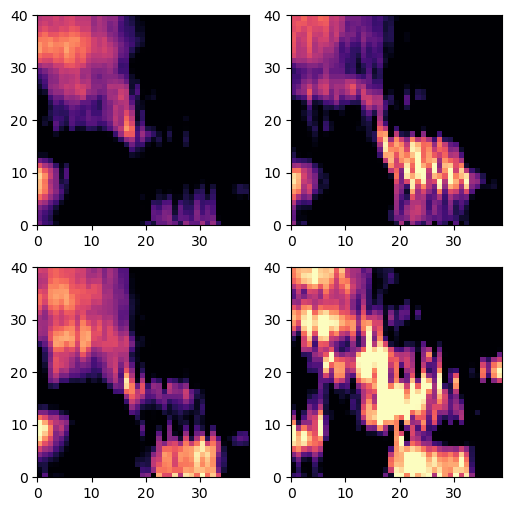

In [17]:
# create some indices
s12_ix = bhv['state'] < 3
s3_ix = bhv['state'] == 3
sacc1 = bhv['n_sacc'] == 1
sacc2 = bhv['n_sacc'] == 2

single_sacc_s2_coh = np.nanmean(coh_trials[:,:, s12_ix & sacc1], axis=2)
double_sacc_s2_coh = np.nanmean(coh_trials[:,:, s12_ix & sacc2], axis=2)

single_sacc_s3_coh = np.nanmean(coh_trials[:,:, s3_ix & sacc1], axis=2)
double_sacc_s3_coh = np.nanmean(coh_trials[:,:, s3_ix & sacc2], axis=2)

f_mean = np.mean(np.concatenate((single_sacc_s2_coh, double_sacc_s2_coh, 
                                 single_sacc_s3_coh, double_sacc_s3_coh), axis=1), axis=1)

f_mean = f_mean.reshape(len(f_mean), 1)

f_std = np.std(np.concatenate((single_sacc_s2_coh, double_sacc_s2_coh, 
                                single_sacc_s3_coh, double_sacc_s3_coh), axis=1), axis=1)

f_std = f_std.reshape(len(f_mean), 1)

z_single_state2 = (single_sacc_s2_coh - f_mean) / f_std
z_double_state2 = (double_sacc_s2_coh - f_mean) / f_std

z_single_state3 = (single_sacc_s3_coh - f_mean) / f_std
z_double_state3 = (double_sacc_s3_coh - f_mean) / f_std

cmin = 0
cmax = 2
ymin = 0
ymax = 40
xmin = np.argmin(np.abs(ts - -1000))
xmax = np.argmin(np.abs(ts - 1000))

xticks = np.array([-1000, -500, 0, 500, 1000])
xtick_ix = [np.argmin(np.abs(ts - xtick)) - 1 for xtick in xticks]

fig, ax = plt.subplots(2, 2, figsize=(6, 6), dpi=100)

ax[0,0].pcolor(z_single_state2, vmin = cmin, vmax=cmax, cmap='magma')
ax[0,0].set_ylim(ymin, ymax)
ax[0,0].set_xlim(xmin, xmax)

ax[0,1].pcolor(z_double_state2, vmin = cmin, vmax=cmax, cmap='magma')
ax[0,1].set_ylim(ymin, ymax)
ax[0,1].set_xlim(xmin, xmax)


ax[1,0].pcolor(z_single_state3, vmin = cmin, vmax=cmax, cmap='magma')
ax[1,0].set_ylim(ymin, ymax)
ax[1,0].set_xlim(xmin, xmax)


ax[1,1].pcolor(z_double_state3, vmin = cmin, vmax=cmax, cmap='magma')
ax[1,1].set_ylim(ymin, ymax)
ax[1,1].set_xlim(xmin, xmax)

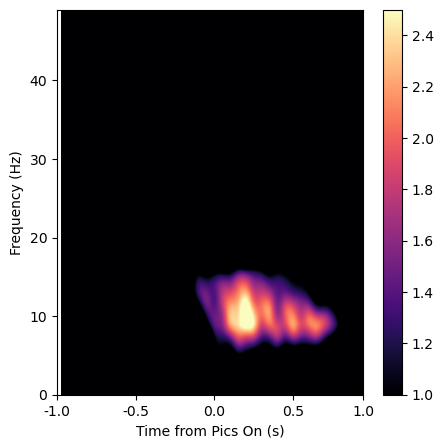

In [22]:
xticks = np.array([-1000, -500, 0, 500, 1000])
xtick_ix = [np.argmin(np.abs(ts - xtick)) - 1 for xtick in xticks]

diff_z = z_double_state2 - z_single_state2

plt.figure(figsize=(5,5))
plt.imshow(diff_z, cmap='magma', interpolation='bicubic', vmin = 1, vmax = 2.5)


# Customize plot
plt.xlabel('Time from Pics On (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0,49)
plt.xticks(xtick_ix, xticks/1000)
plt.xlim(xtick_ix[0],xtick_ix[-1])
plt.colorbar()

C:\Users\Thomas Elston\AppData\Local\Temp\ipykernel_25324\2335611440.py:6: RuntimeWarning: Mean of empty slice
  choice_coh = np.nanmean(coh_trials[:, pics_on:pics_off,:], axis=1).T


(0.25, 0.52)

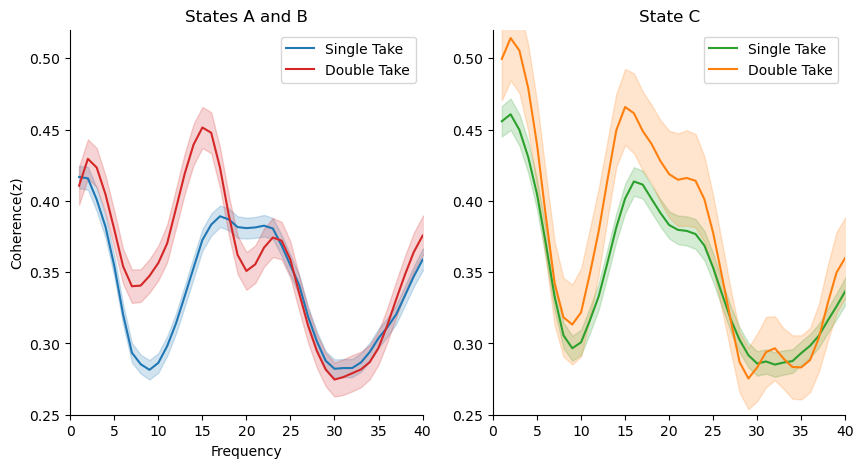

In [19]:
# compare coherences across the choice period
pics_on = np.argmin(np.abs(ts - 0))
pics_off = np.argmin(np.abs(ts - 400))


choice_coh = np.nanmean(coh_trials[:, pics_on:pics_off,:], axis=1).T
# z_choice_coh = zscore(choice_coh, axis=0, nan_policy='omit')
# choice_coh = z_choice_coh

s12_sacc1_mean = np.nanmean(choice_coh[sacc1 & s12_ix, :], axis=0)
s12_sacc1_sem = np.nanstd(choice_coh[sacc1 & s12_ix, :], axis=0) / np.sqrt(np.sum(s12_ix & sacc1))

s12_sacc2_mean = np.nanmean(choice_coh[sacc2 & s12_ix, :], axis=0)
s12_sacc2_sem = np.nanstd(choice_coh[sacc2 & s12_ix, :], axis=0) / np.sqrt(np.sum(s12_ix & sacc2))

s3_sacc1_mean = np.nanmean(choice_coh[sacc1 & s3_ix, :], axis=0)
s3_sacc1_sem = np.nanstd(choice_coh[sacc1 & s3_ix, :], axis=0) / np.sqrt(np.sum(s3_ix & sacc1))

s3_sacc2_mean = np.nanmean(choice_coh[sacc2 & s3_ix, :], axis=0)
s3_sacc2_sem = np.nanstd(choice_coh[sacc2 & s3_ix, :], axis=0) / np.sqrt(np.sum(s3_ix & sacc2))


fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)


ax[0].plot(freqs, s12_sacc1_mean, color='tab:blue', label = 'Single Take')
ax[0].fill_between(freqs, s12_sacc1_mean - s12_sacc1_sem, s12_sacc1_mean + s12_sacc1_sem,
                 alpha=.2, color='tab:blue')

ax[0].plot(freqs, s12_sacc2_mean, color='tab:red', label = 'Double Take')
ax[0].fill_between(freqs, s12_sacc2_mean - s12_sacc2_sem, s12_sacc2_mean + s12_sacc2_sem,
                 alpha=.2, color='tab:red')

ax[0].legend()
ax[0].set_xlim(0, 40)
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Coherence(z)')
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].set_title('States A and B')
ax[0].set_ylim((.25, .52))


ax[1].plot(freqs, s3_sacc1_mean, color='tab:green', label = 'Single Take')
ax[1].fill_between(freqs, s3_sacc1_mean - s3_sacc1_sem, s3_sacc1_mean + s3_sacc1_sem,
                 alpha=.2, color='tab:green')

ax[1].plot(freqs, s3_sacc2_mean, color='tab:orange', label = 'Double Take')
ax[1].fill_between(freqs, s3_sacc2_mean - s3_sacc2_sem, s3_sacc2_mean + s3_sacc2_sem,
                 alpha=.2, color='tab:orange')
ax[1].set_xlim(0, 40)
ax[1].legend()
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].set_title('State C')
ax[1].set_ylim((.25, .52))
